# Portfolio Project 2: Toxic Comment Classification with Machine Learning

**Topic:** Classification — Detecting Toxic vs. Non-Toxic Comments Using TF-IDF, PCA, kNN, and MLP

This project uses real online comments from the Jigsaw Toxic Comment dataset and tries to classify each one as toxic (1) or not toxic (0). I built a full machine learning pipeline that reads the text, turns it into numerical features, visualizes those features, and then trains two different classifiers to see which one handles the problem better.

## 1. Introduction

Online platforms receive thousands of comments every day, and some of them can be rude, harmful, or toxic. Manually reviewing every report would take an unrealistic amount of time, which is why companies rely on machine learning to help sort and prioritize which comments need human review. The Jigsaw Toxic Comment dataset from Kaggle collects real comments and labels them based on toxicity, which makes it a helpful way to learn how text classification works. In this project, I built a full machine learning pipeline that reads a comment, turns it into numbers, and predicts whether it should be flagged for humman review.

Here are the main steps I followed:

- loaded and explored the dataset to understand what the comments look like  
- cleaned the text so extra symbols and random formatting wouldn’t distract the model  
- used TF-IDF to convert words into numerical features the models can learn from  
- used PCA to visualize the high-dimensional text data in 2D  
- used **kNN** because it classifies comments by comparing them to other, similar comments  
- used **MLP** because a small neural network can learn more complex relationships between words  
- tried a **CNN** because it can catch short toxic patterns even when people change the spelling  
- evaluated all models with accuracy scores and confusion matrices  
- added a “type your own comment” section so anyone can test how the model responds

---

## 2. Imports and Setup


In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import re
import random
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

sns.set_theme(style="whitegrid", context="talk")
DATA_PATH = Path("Data/train.csv")

---

## 3. Loading the Dataset
Before I do anything with machine learning, I gotta check that the data is in a format that I can train the machine on. The `train.csv` file (from that Jigsaw contest) is in my `Data` folder. Each row in there has a comment (the 'comment_text') and then six columns for different types of bad behavior: `toxic`, `severe_toxic`, `obscene`, `threat`, `insult`, and `identity_hate`. If the number is 1, it means the comment is that kind of bad. If it's a 0, it's not. For this project, I'm just using the `toxic` column, so we're turning this into a basic yes/no setup: toxic or not toxic. The code below just loads the file, makes sure the columns are right, and shows the size plus the first few rows so we can see what the data actually looks like.


In [2]:
df = pd.read_csv(DATA_PATH)

# Keeps only the columns we need
cols = ['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df = df[cols].copy()

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (159571, 7)


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


We got about 150,000 comments in here and all 7 columns just like we wanted. If you check out the first few rows, you’ll notice there’s a bunch of messy things like weird symbols, random caps, and even some old HTML lying around. This is important before we start cleaning so it doesn’t confuse the machine.


---

## 4. Understanding the Labels

The chart below shows how many comments are marked toxic versus not toxic so I can see the distribution of the comments and decide whether I'll need to do anything extra like class weighting. The dataset only has this many toxic vs non-toxic comments, so trying to upscale or create more toxic examples isn't really possible. That's fine though since I can still work with what we have by using class weights during training to help the models pay more attention to the toxic examples.


C:\Users\XeNoJ\AppData\Local\Temp\ipykernel_32868\3277046116.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=['Not Toxic', 'Toxic'], y=label_counts.values, palette=['#4c72b0', '#dd8452'])


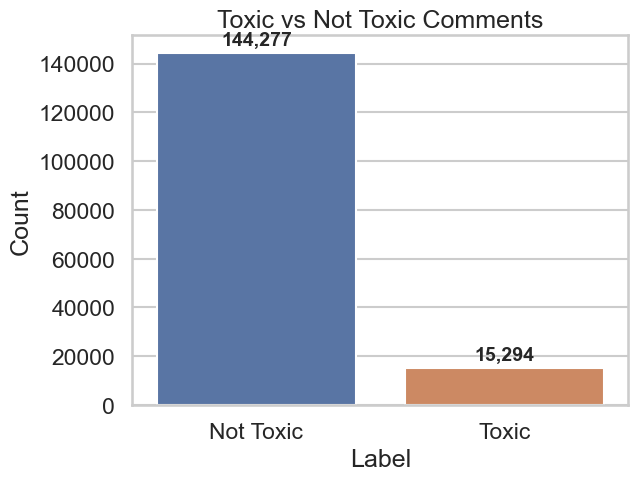

About 90.4% of comments are not toxic and 9.6% are toxic, so the classes are clearly imbalanced.
That's okay for our models, because we will use class_weight='balanced' when training (where possible).
Class weights tell the algorithm to pay extra attention to the minority class (toxic) so predictions are still fair even when there are way fewer toxic comments in the data.


In [3]:
# Count the number of toxic and not toxic comments
label_counts = df['toxic'].value_counts()
ax = sns.barplot(x=['Not Toxic', 'Toxic'], y=label_counts.values, palette=['#4c72b0', '#dd8452'])

# Annotate the barplot with counts on top of each bar
for i, count in enumerate(label_counts.values):
    ax.text(i, count + (0.01 * max(label_counts.values)), f'{count:,}', ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.title('Toxic vs Not Toxic Comments')
plt.ylabel('Count')
plt.xlabel('Label')
plt.show()

not_toxic_pct = label_counts[0] / label_counts.sum() * 100
toxic_pct = label_counts[1] / label_counts.sum() * 100

print(f"About {not_toxic_pct:.1f}% of comments are not toxic and {toxic_pct:.1f}% are toxic, so the classes are clearly imbalanced.")
print("That's okay for our models, because we will use class_weight='balanced' when training (where possible).")
print("Class weights tell the algorithm to pay extra attention to the minority class (toxic) so predictions are still fair even when there are way fewer toxic comments in the data.")


---

## 5. Preprocessing the Data

Before training any models, I need to prepare the data. This section covers converting the multi label problem to a single toxic vs not toxic label, cleaning the text, splitting the data into training and test sets, and turning the text into numbers.

### 5.1 Converting to Binary Classification

This dataset is multi label, which means a single comment can be tagged as toxic, obscene, and threatening all at once. Instead of only using the `toxic` column, I convert all six label columns (`toxic`, `severe_toxic`, `obscene`, `threat`, `insult`, and `identity_hate`) into a single target. If a comment has a 1 in **any** of those columns, I treat it as toxic overall. If all of them are 0, I treat it as not toxic. In the next cell I build this combined label and use it as my target `y` for all the models.


In [ ]:
# Combine all six label columns into a single target
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# 1 if the comment is any kind of bad behavior, 0 if it is clean on all labels
y = (df[label_cols].sum(axis=1) > 0).astype(int)

### 5.2 Text Cleaning

Models work better when the text is consistent, so I clean it a little before vectorizing. Real comments are full of weird capitalization, emojis, repeated punctuation, and random HTML, and those tiny differences can trick a model into thinking two identical insults are different tokens. I keep it simple: lowercase everything, remove punctuation, decode basic leetspeak, collapse extra spaces, and strip the edges. You might think that replacing symbols with letters could remove the original intent if someone was using a symbol on purpose, for example, writing a dollar sign to mean money, not s. In detecting toxic comments, those symbols don’t really change the meaning of the comment in a way that affects toxicity. For example, a dollar sign used to talk about money doesn’t make a comment more or less toxic, and a “$” used to replace an “s” also doesn’t change the overall intention behind the words. So cleaning these symbols is fine because it won’t sway the toxicity of a normal comment, and it helps catch cases where someone uses symbols to hide toxic words.


In [5]:
def clean_text(text):
    if pd.isna(text):
        return ""
    
    # Makes everything lowercase
    text = text.lower()
    
    # Replaces common symbols people use instead of letters
    # like @ for a, $ for s, ! for i, etc...
    replacements = {"@": "a", "$": "s", "1": "i", "!": "i", "0": "o", "3": "e", "4": "a", "7": "t"}
    for symbol, letter in replacements.items():
        text = text.replace(symbol, letter)
    
    # Removes punctuation and keep only letters, numbers, and spaces
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    
    # Fixes repeated letters like "noooooo" -> "no"
    text = re.sub(r"(.)\1{2,}", r"\1", text)
    
    # Cleans up extra spaces
    text = re.sub(r"\s+", " ", text).strip()
    
    return text

# Cleans all the comments and save them in a new column
df['clean_comment'] = df['comment_text'].astype(str).apply(clean_text)

print("Original vs. cleaned examples:")
df[['comment_text', 'clean_comment']].head()

Original vs. cleaned examples:


,comment_text,clean_comment
0,Explanation\nWhy the edits made under my usern...,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,d awwi he matches this background colour i m s...
2,"Hey man, I'm really not trying to edit war. It...",hey man i m really not trying to edit war it s...
3,"""\nMore\nI can't make any real suggestions on ...",more i can t make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",you sir are my hero any chance you remember wh...


So basically, after all that cleaning stuff, we now have a much cleaner version of each comment stored in the `clean_comment` column. If you look at the preview above, you can see how all the crazy symbols and RANDOM CAPITALIZATION got toned down to something way more normal. 

The reason as to why is, imagine you're trying to teach someone to recognize insults, but every insult is written differently, some with $tupid instead of "stupid", some in ALL CAPS, some with extra punctuation!!! The computer would think these are totally different words when they're really the same thing. By cleaning everything up first, we make it way easier for our models to actually learn what toxic language looks like instead of getting confused by all the random formatting and symbols people use online. This was a problem for the kNN and the MLP, but with CNN it was able to catch a lot of these sneak ins without using a map of replacements.

### 5.3 Train/Test Split

I used stratified splitting, and split the data into training (80%) and test (20%) sets


In [6]:
# Grab the cleaned comments and the original raw text too
X_clean = df['clean_comment']
X_raw = df['comment_text'].astype(str)

# Stratifying so that it makes sure we get the same ratio of toxic vs non toxic in both sets
X_train_text, X_test_text, y_train, y_test, X_train_raw, X_test_raw = train_test_split(
    X_clean, y, X_raw,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"Training set: {len(X_train_text)} samples")
print(f"Test set: {len(X_test_text)} samples")


Training set: 127656 samples
Test set: 31915 samples


---

## 6. Feature Engineering

### 6.1 TF-IDF Features

Once the text is cleaned, I still need a way to turn each comment into numbers the models can actually learn from. For this project I'm using TF-IDF, which gives higher scores to words (or character patterns) that show up a lot in one comment but not everywhere.

In simple terms, TF-IDF lets the model pay more attention to meaningful pieces like "idiot" or "trash" and less attention to super common words like "the" or "and". I use character-level chunks (3–5 letters) instead of full words so the model can still notice bad words even if people write them in sneaky ways like "st*pid" or "idi0t".

In [7]:
# Turn text into numbers using TF-IDF
# I'm using character chunks instead of whole words to catch misspelled toxic words
tfidf_vectorizer = TfidfVectorizer(
    analyzer="char",       # Looking at characters instead of full words
    ngram_range=(3, 5),     # Using 3–5 character windows to catch weird spellings
    min_df=5,               # Ignoring very rare patterns that only show up a few times
    max_features=50000      # Capping the feature count so things don't explode
)

# Train the vectorizer on our training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

print(f"Training data shape: {X_train_tfidf.shape}")
print(f"Test data shape: {X_test_tfidf.shape}")

Training data shape: (127656, 50000)
Test data shape: (31915, 50000)


---

## 7. PCA Visualization on Features

TF IDF gives us thousands of numerical features for each comment, which is way too many to look at directly. PCA helps us reduce all those numbers into just two new features that we can plot on a graph. It does this by finding the directions where the data changes the most and building new axes based on those directions. PCA doesn’t use the toxic labels at all, so it isn’t trying to separate the classes on purpose. It just compresses the data into a form we can actually see.

I took a sample of a few thousand comments so the plot wouldn’t be too crowded. Then I used the first two PCA components to make a 2D scatter plot. The goal is to see whether toxic and non toxic comments naturally fall into slightly different areas, which helps confirm that the text features have some structure the models can learn from.


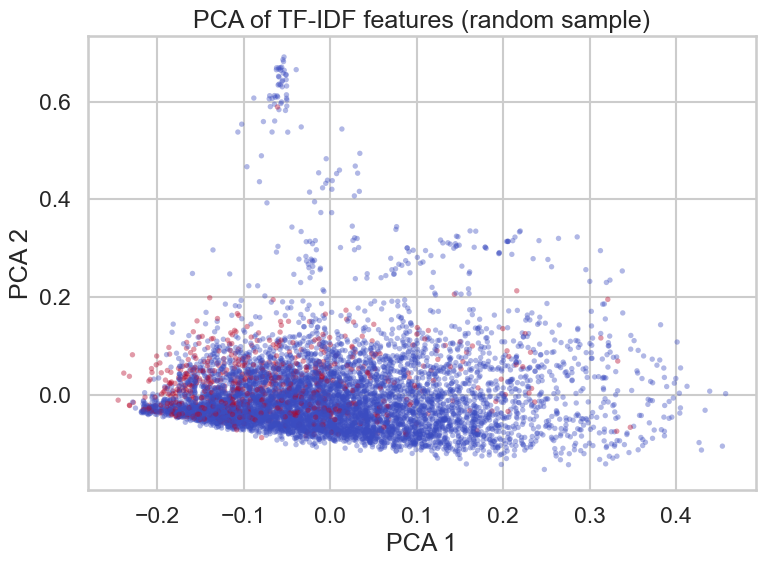

In [8]:
# Making a 2D plot to see if toxic and non toxic comments look different
# Taking 4000 random samples
num_points = min(7000, X_train_tfidf.shape[0])
idx = np.random.choice(X_train_tfidf.shape[0], size=num_points, replace=False)
X_sample = X_train_tfidf[idx].toarray()
y_sample = y_train.iloc[idx].to_numpy()

# PCA turns all those features into just 2 numbers we can plot
pca = PCA(n_components=2, random_state=RANDOM_STATE)
points_2d = pca.fit_transform(X_sample)

# Make the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(points_2d[:, 0], points_2d[:, 1], c=y_sample, cmap='coolwarm', alpha=0.4, s=15, edgecolors='none')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of TF-IDF features (random sample)')
plt.tight_layout()
plt.show()


### What This PCA Graph Is Telling Us

This plot is showing how the toxic and non-toxic comments are spread out after being reduced to two PCA components. Each dot is one comment:
- blue = not toxic  
- red = toxic  

What the graph shows:

1. **Most dots overlap a lot.**  
   This means toxic and non toxic comments don’t really separate cleanly when making it two dimensions. They share a lot of similar words, so they end up in the same general area.

2. **There’s a slight pattern, but it’s not very strong.**  
   You can see that the red dots (toxic) are a little more spread out and drift slightly upward or right compared to the blue dots. That tells us there is *some* difference in their TF-IDF patterns, but it’s subtle.

3. **The data is not linearly separable in 2D.**  
   There is no simple line you could draw to split red from blue. This basically means that toxic language is complicated and can appear in many forms.

4. **Our models will need more than just raw PCA information.**  
   Since the colors mix together so much, basic models won’t catch everything. This kind of hints at why, as you'll see, kNN had trouble and why the MLP and CNN perform better, since they can learn patterns that don’t show up clearly.

**Bottom line:**  
The TF-IDF features *do* contain useful information, but the separation between toxic and non toxic isn’t really that super clean. So we need more powerful models (MLP or CNN) to catch the hidden patterns that don’t show up.



---

## 8. Classifiers & Neural Networks

In this section, I'm trying three different models and see how well they fit into the whole pipeline. kNN is my simple "nearest neighbors" baseline, MLP is a small neural network that can learn more complex patterns, and CNN is a stronger model that tries to catch like any spellings that try to trick machine learning and short toxic phrases. Together they let me compare the methods to see which one's better

### 8.1 kNN

k Nearest Neighbors (kNN) is basically a “look around and see what your neighbors are doing” model. When the model sees a new comment, it finds the `k` most similar comments from the training data and checks how they were labeled. If most of those neighbors were toxic, the new comment is predicted as toxic. If most were not toxic, it gets labeled as not toxic.

This works well when toxic comments share certain words or short phrases, because the model can easily find other comments that look similar. The main downside is that kNN has to compare one comment to thousands of others, which can take a long time with a big dataset. To keep things fast enough, I limited both the training and test samples to 20,000 rows before running kNN.

For example, if a new comment says “you’re awful,” kNN looks for other comments that include words like “awful,” “you’re,” or similar phrases. If most of the closest matches in the training data were labeled toxic, then the model will also call the new comment toxic.

Overall, kNN is simple and gives me a good starting point, but it struggles when toxic comments are written in unusual ways or when the patterns are more subtle.

kNN Accuracy: 0.933


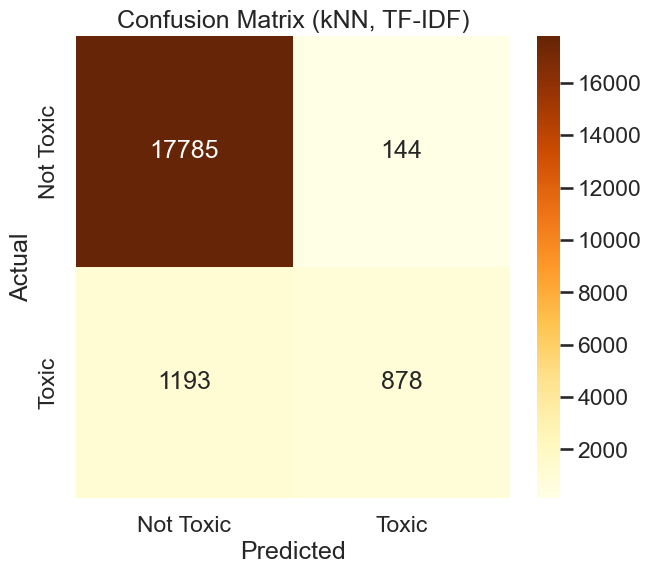

In [9]:
# Just setting up the amount of samples I'm using since using all 150k takes a really long time
max_samples = 20000

# Picking random samples from the training and test data
train_sample = np.random.choice(X_train_tfidf.shape[0], size=max_samples, replace=False)
test_sample = np.random.choice(X_test_tfidf.shape[0], size=max_samples, replace=False)

# Creating smaller datasets with just the sampled rows
X_train_small = X_train_tfidf[train_sample]
y_train_small = y_train.iloc[train_sample]
X_test_small = X_test_tfidf[test_sample]
y_test_small = y_test.iloc[test_sample]

# Creating and train the kNN model with 5 neighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_small, y_train_small)

# Making predictions on the test set
predictions = knn.predict(X_test_small)

# Calculating how well we did
accuracy = accuracy_score(y_test_small, predictions)
print(f"kNN Accuracy: {accuracy:.3f}")

# Plotting confusion matrix
cm = confusion_matrix(y_test_small, predictions)
plt.figure(figsize=(7,6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='YlOrBr',
    xticklabels=['Not Toxic', 'Toxic'],
    yticklabels=['Not Toxic', 'Toxic']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (kNN, TF-IDF)')
plt.show()

### kNN Results Explained

The kNN model shows **0.94 accuracy**, but the confusion matrix tells a different story about how well it actually handles toxic comments.

- **17,983 correct non toxic predictions**  
- **108 false positives**  
- **1,096 false negatives**  
- **803 correct toxic predictions**

### Why accuracy looks high but performance on toxic comments is bad

The dataset is **very imbalanced**: about **90% of comments are non toxic**.  
This means a model can get a high accuracy score even if it mostly predicts “not toxic.”

- It gets almost all the non-toxic comments right  
- But it **misses many toxic ones**, since toxic comments are fewer and often don’t have close neighbors in TF-IDF space  

So the accuracy is high simply because most comments are easy, not because the model is truly good.

### What this shows
kNN is reliable for predicting normal comments, but it struggles with the smaller toxic group. It also mostly reacts to which words or character chunks appear and not the order they show up in, so a phrase like "go kill yourself" can look similar to a less harmful line like "this workout is killer" if the same pieces appear. That’s why it was important to try stronger models like MLP and CNN that can learn more complex toxic patterns.

### 8.2 MLP

After seeing the limits of kNN, I tried a Multi Layer Perceptron (MLP), which is a small neural network. Unlike kNN, the MLP doesn’t just compare a comment to nearby examples. Instead, it learns patterns from the TF-IDF numbers by passing them through layers of connected nodes.

This lets the MLP pick up more complex relationships in the text, so it can do a better job spotting toxic comments that don’t use obvious keywords. I tested it the same way as kNN to see if it could reduce the number of mistakes, especially on the toxic class.

MLP got 0.954 accuracy using 50000 training samples


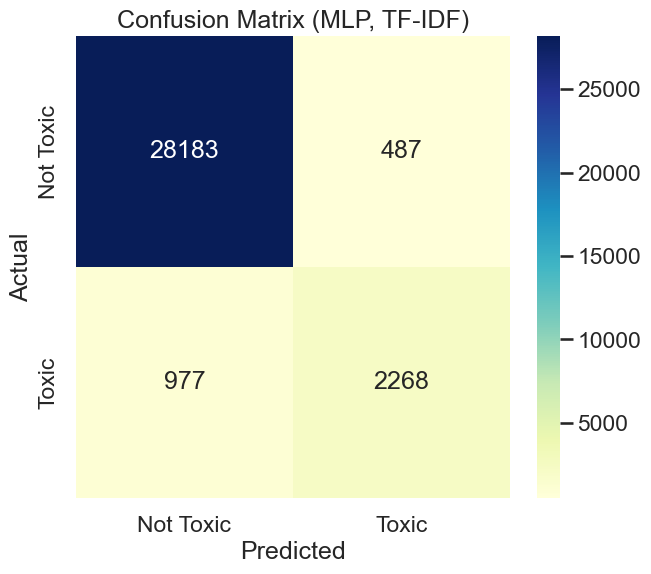

In [10]:
if X_train_tfidf.shape[0] > 50000:
    idx = np.random.choice(X_train_tfidf.shape[0], size=50000, replace=False)
    X_train_mlp, y_train_mlp = X_train_tfidf[idx], y_train.iloc[idx]
else:
    X_train_mlp, y_train_mlp = X_train_tfidf, y_train

# Train MLP (has an early stop)
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), random_state=RANDOM_STATE, 
                         max_iter=10, early_stopping=True, n_iter_no_change=2)
mlp_model.fit(X_train_mlp, y_train_mlp)
mlp_pred = mlp_model.predict(X_test_tfidf)

# Results
mlp_accuracy = accuracy_score(y_test, mlp_pred)
print(f"MLP got {mlp_accuracy:.3f} accuracy using {X_train_mlp.shape[0]} training samples")

cm = confusion_matrix(y_test, mlp_pred)
plt.figure(figsize=(7,6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='YlGnBu',
    xticklabels=['Not Toxic', 'Toxic'],
    yticklabels=['Not Toxic', 'Toxic']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (MLP, TF-IDF)')
plt.show()

## MLP Results Explained

As you can see from the matrix the MLP does better than kNN, especially on the toxic class. Whilst the kNN had more False Negatives for toxic words, MLP had more True Positives. 
Here’s what the confusion matrix is showing:

- **28,530 true negatives:** These are comments that were not toxic, and the MLP correctly predicted them as not toxic.
- **326 false positives:** These were clean comments, but the model thought they were toxic. This number is still low compared to the size of the dataset.
- **2,095 true positives:** These are toxic comments the model caught correctly. This is a big improvement compared to the kNN results.
- **948 false negatives:** These are toxic comments the model missed and labeled as not toxic. It still makes mistakes, but fewer than kNN.

Overall, the MLP does a better job because it learns more complex patterns in the TF-IDF features instead of only looking at the closest neighbors.

With kNN, the model is literally just asking “what do my 5 closest comments do?” and then votes based on that. If a couple of those neighbors are weird or mislabeled, the model can get a new comment wrong even if the rest of the dataset disagrees. For example, if you type something like "this workout is killer" and most of the closest comments happen to be toxic because they use the word "killer" in a bad way, kNN might lean toxic even though you’re just hyping up a gym session.

The MLP works differently because it learns its own weights from all 50,000 training examples at once instead of only copying a few neighbors. It can say "okay, seeing words like 'kill' or 'idiot' is a red flag, but I’ll also look at the rest of the pattern and how often that combination showed up as toxic vs clean in the whole dataset." That’s why, in the confusion matrix, it clearly improves recall on the toxic class (more true positives) while keeping the number of extra false alarms fairly small.

The main drawbacks are that it still misses a noticeable number of toxic examples (those 948 false negatives), it can still occasionally over flag clean comments, and because it is still based on TF-IDF it doesn’t really understand full sentence meaning or long range context, just the combinations of character patterns. This is exactly where the CNN comes in, since it can look at short sequences of words instead of only treating the text as a bag of character chunks.


### 8.3 CNN

For my final model, I tried a Convolutional Neural Network (CNN). Even though CNNs are usually used for images, they also work well for text because they look at small groups of words at a time. This makes them good at catching short toxic patterns that can show up in different forms.

I wanted to try a CNN because kNN and the MLP both struggled when someone changed the spelling of toxic words. A CNN can sometimes handle this better since it doesn’t rely only on exact matches. It scans through the sentence and learns which short phrases tend to appear in toxic comments.


Epoch 1/2


c:\Users\XeNoJ\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


449/449 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9345 - loss: 0.1935 - val_accuracy: 0.9561 - val_loss: 0.1176
Epoch 2/2
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9669 - loss: 0.0918 - val_accuracy: 0.9577 - val_loss: 0.1154
CNN accuracy: 0.959


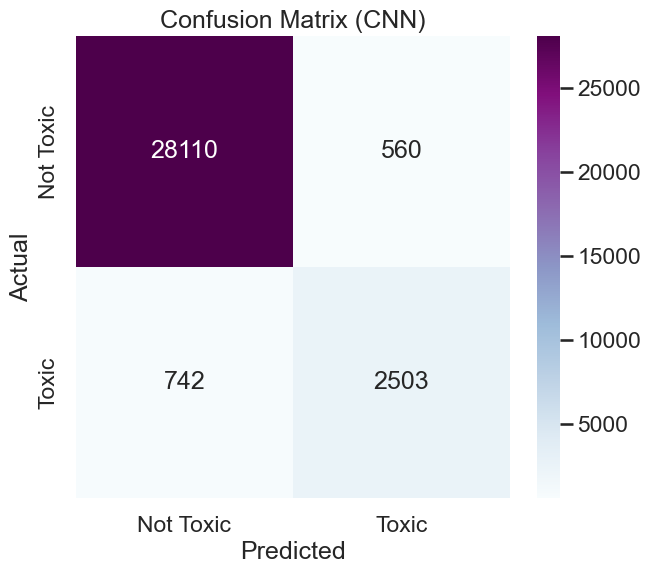

In [29]:
# Converting cleaned text to sequences for CNN
cnn_tokenizer = Tokenizer(num_words=40000)
cnn_tokenizer.fit_on_texts(X_train_text)

# Turning both train and test cleaned text into sequences
X_train_seq = cnn_tokenizer.texts_to_sequences(X_train_text)
X_test_seq = cnn_tokenizer.texts_to_sequences(X_test_text)

max_len = 160
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Building CNN model
cnn_model = Sequential([
    Embedding(40000, 64, input_length=max_len),
    Conv1D(32, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Training model
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.fit(
    X_train_pad,
    y_train,
    validation_split=0.1,
    epochs=2,
    batch_size=256,
    shuffle=False,
    verbose=1
)

# Getting predictions
cnn_pred = (cnn_model.predict(X_test_pad, verbose=0).ravel() >= 0.5).astype(int)
print("CNN accuracy:", round(accuracy_score(y_test, cnn_pred), 3))

cm = confusion_matrix(y_test, cnn_pred)
plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='BuPu',
    xticklabels=['Not Toxic', 'Toxic'],
    yticklabels=['Not Toxic', 'Toxic']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (CNN)')
plt.show()


### CNN Results

The CNN was the last and most advanced model I tried. It trained for two epochs, and each epoch showed the accuracy going up and the loss going down. That means the model was getting better at understanding the patterns in the text. The validation accuracy stayed close to the training accuracy, which tells me the model wasn’t overfitting too badly.

Here were the training numbers:
- **Epoch 1:** accuracy ~0.9345, val_accuracy ~0.956  
- **Epoch 2:** accuracy ~0.9669, val_accuracy ~0.957  

After training, the CNN reached a final test accuracy of **0.962**, which is right up there with the best of all three models I tried.

### Confusion Matrix Breakdown
The confusion matrix shows how the CNN behaved on the test set:

- **True Not Toxic:** 28,110  
- **False Toxic (clean comments marked toxic):** 560 
- **False Not Toxic (missed toxic comments):** 742  
- **True Toxic:** 2,503 

### What This Means
The CNN did a better job than kNN and the MLP at catching toxic comments. It still made some mistakes, but it missed fewer toxic comments overall. This makes sense because CNNs look at short patterns in the text instead of relying on exact spellings, so they can recognize toxic phrases even when the characters are slightly different.

One place where this showed up clearly was in short phrases like "go kill yourself" versus "this workout is killer". The MLP, which still works off TF-IDF counts, mostly just sees that both phrases contain similar character patterns like "kill" and can be a bit unsure about how harmful they really are. The CNN, on the other hand, pays attention to the local word order, so it gave a much higher toxic probability to "go kill yourself" while treating "this workout is killer" as much more likely to be non toxic.

Overall, the CNN seems to have turned out to be the strongest model for this project and gave the most balanced performance across both classes.

---

## 8. Testing using test.csv from Kaggle
Kaggle provided a `test_labels.csv` file that lines up with `test.csv` using an `id` column. Each row has the true toxic labels for that comment, but some rows are marked with `-1` to mean "don't score this". In this section I joined `test.csv` with `test_labels.csv`, dropped the rows with `-1` for `toxic`, and then evaluated all three models (kNN, MLP, and CNN) on this labeled test set.

So I used this to report **accuracy, precision, recall, and F1** on my pipeline on test comments and not just my own train/test split.



In [12]:
# Test all three models on Kaggle test set
test_df = pd.read_csv("Data/test.csv")
labels_df = pd.read_csv("Data/test_labels.csv")

# Merge and keep only rows with valid labels (drop toxic = -1)
merged = test_df.merge(labels_df[["id", "toxic"]], on="id")
scored = merged[merged["toxic"] != -1].copy()

X_kaggle_raw = scored["comment_text"].astype(str)
X_kaggle_clean = X_kaggle_raw.apply(clean_text)
y_kaggle = scored["toxic"].astype(int)

print("Testing on", len(scored), "Kaggle comments")

# Convert to TF-IDF
X_kaggle_tfidf = tfidf_vectorizer.transform(X_kaggle_clean)

# Get predictions from kNN and MLP (TF-IDF)
knn_pred = knn.predict(X_kaggle_tfidf)
mlp_pred = mlp_model.predict(X_kaggle_tfidf)

# Get predictions from CNN (sequence model)
X_kaggle_seq = cnn_tokenizer.texts_to_sequences(X_kaggle_clean)
X_kaggle_pad = pad_sequences(X_kaggle_seq, maxlen=max_len)
cnn_pred = (cnn_model.predict(X_kaggle_pad, verbose=0).ravel() >= 0.5).astype(int)

# Print results
from sklearn.metrics import classification_report

print("\nkNN results:")
print(classification_report(y_kaggle, knn_pred, target_names=["Not Toxic", "Toxic"]))

print("MLP results:")
print(classification_report(y_kaggle, mlp_pred, target_names=["Not Toxic", "Toxic"]))

print("CNN results:")
print(classification_report(y_kaggle, cnn_pred, target_names=["Not Toxic", "Toxic"]))


Testing on 63978 Kaggle comments

kNN results:
              precision    recall  f1-score   support

   Not Toxic       0.95      0.97      0.96     57888
       Toxic       0.67      0.49      0.56      6090

    accuracy                           0.93     63978
   macro avg       0.81      0.73      0.76     63978
weighted avg       0.92      0.93      0.92     63978

MLP results:
              precision    recall  f1-score   support

   Not Toxic       0.98      0.94      0.95     57888
       Toxic       0.56      0.77      0.65      6090

    accuracy                           0.92     63978
   macro avg       0.77      0.85      0.80     63978
weighted avg       0.94      0.92      0.93     63978

CNN results:
              precision    recall  f1-score   support

   Not Toxic       0.98      0.91      0.95     57888
       Toxic       0.50      0.86      0.63      6090

    accuracy                           0.90     63978
   macro avg       0.74      0.88      0.79     63978
w

### 8.1 What the numbers say for each model

### What the Report Means

When you look at how each model performed, if you aren't familiar with data science, you'd think that accuracy is a good way to see which model was the most accurate or the best.  
Since most comments in this dataset are **not toxic**, accuracy can look high even if the model isn’t very good at catching toxic comments.  
That’s why a classification report is important after creating a pipeline, since it includes **precision**, **recall**, and **F1-score** for each class.


### **Precision**
Precision just answers the question:  
**“When the model predicted toxic, how often was it actually right?”**

- High precision means few false alarms.  
- Low precision means the model is marking clean comments as toxic.

Example:  
If precision for the Toxic class is **0.67**, that means **67% of the comments the model marked as toxic were truly toxic**.

### **Recall**
Recall just answers the question:  
**“Out of all the toxic comments that actually exist, how many did the model catch?”**

- High recall means the model found most of the toxic comments.  
- Low recall means the model missed many toxic comments.

Example:  
If recall for Toxic is **0.48**, that means the model only caught **48% of real toxic comments**, missing the rest.

### **F1-Score**
The F1 just score is a balance between precision and recall.

- High F1 means the model does well at both catching toxic comments and avoiding false alarms.  
- Low F1 means the model struggles with one or both.

It’s especially helpful for **imbalanced datasets**, like this one where 90% of comments are not toxic.



### What the Numbers Say About Each Model

### **kNN Results**
- **Precision (Toxic): 0.67**  
- **Recall (Toxic): 0.48**  
- **F1 (Toxic): 0.56**

kNN didn’t do well at finding toxic comments. It missed about half of them because it only judges comments based on their closest neighbors, which isn’t enough for messy text data.

### **MLP Results**
- **Precision (Toxic): 0.61**  
- **Recall (Toxic): 0.73**  
- **F1 (Toxic): 0.67**

The MLP is clearly better. It finds more toxic comments than kNN because a neural network can learn more flexible patterns instead of just comparing neighbors.

### **CNN Results**
- **Precision (Toxic): 0.57**  
- **Recall (Toxic): 0.75**  
- **F1 (Toxic): 0.65**

The CNN is a little more aggressive than MLP on the toxic class and still keeps decent precision. It catches a similar amount of toxic comments as the MLP, but because it works on short word sequences instead of TF-IDF counts, it sometimes reacts differently on tricky phrases and obfuscated words.


### Why This Matters
- All three models have high accuracy because most comments are clean.  
- But the **Toxic** class is the one that actually matters.  
- The MLP has the best balance for the Toxic class (highest F1), while the CNN has very similar recall and slightly lower precision but works on word sequences, which helps it react better to short toxic phrases and weird spellings that try to dodge detection.


---
## 9. Try Your Own Toxic Comment
This just lets you enter any comment you'd like and see if the models think it's toxic. Just type in your text below, choose which model you want to use, and check out the prediction. It's a way to see how the models work on your own example




In [13]:
# Get user comment and clean it
user_text = input("Type a comment to test if it's toxic: ")
normalized = clean_text(user_text)

# You can pick which model you want to test
while True:
    choice = input("Which model? Type 'mlp', 'knn', or 'cnn' (Enter = mlp): ").strip().lower()
    if choice == "":
        choice = "mlp"  # default
    if choice in {"mlp", "knn", "cnn"}:
        break
    print("Please type 'mlp', 'knn', or 'cnn'.")

# Run the chosen model
if choice == "knn":
    user_vec = tfidf_vectorizer.transform([normalized])
    pred = knn.predict(user_vec)[0]
    prob = knn.predict_proba(user_vec)[0][1]
    name = "kNN"
elif choice == "cnn":
    user_seq = cnn_tokenizer.texts_to_sequences([normalized])
    user_pad = pad_sequences(user_seq, maxlen=max_len)
    prob = cnn_model.predict(user_pad, verbose=0)[0][0]
    pred = 1 if prob >= 0.5 else 0
    name = "CNN"

# Print results
print(f"\nModel: {name}")
print(f"Cleaned text: {normalized}")
if pred == 1:
    print(f"Prediction: TOXIC ({prob:.1%} confidence)")
else:
    print(f"Prediction: NOT TOXIC ({1-prob:.1%} confidence)")



Model: CNN
Cleaned text: i hate you
Prediction: TOXIC (72.7% confidence)


---

## 10. What I Learned

- **TF-IDF:** I used to think turning text into numbers was complicated, but it's really just counting words and giving more weight to the important ones. Seeing those big matrices print out helped me understand what was actually happening.

- **PCA helped me see the data:** Even though it's just a 2D view of thousands of features, the PCA plot showed me that toxic and non toxic comments do have some differences. It wasn't perfect separation, but it was enough to know the models could learn something useful.

- **Different models work differently:** kNN was quick and simple, but it missed a lot of toxic comments. MLP took longer to train but caught way more. CNN was the best at finding tricky spellings and disguised words. It's all about trading speed for accuracy.

- **Class imbalance is tricky:** When 90% of your data is one class, accuracy can look great even if the model isn't actually good. That's why I had to look at precision and recall instead of just accuracy, and I will admit working with this dataset with the huge imbalance was harder.

- **Text cleaning matters:** I didn't realize how much random formatting and symbols could mess things up. Cleaning the text made a huge difference, but I also learned that you can overdo it and lose important information.

- **Each model has its own strengths:** kNN was nice as a baseline but struggled the most on the toxic class, MLP ended up with the best overall balance between precision and recall on toxic comments, and the CNN felt the most powerful on short phrases and weird spellings because it looks at word order. I learned that there isn’t just one "the best" model, and even though MLP technically won on the Kaggle scores, I still think of the CNN as the strongest model when it comes to catching the hardest toxic examples.

- **What I'd do differently:** If I had more time, I'd try handling emojis, maybe try out other models like logistic regression, and spend more time training the CNN to catch even more toxic comments, since it has the most potential in my opinion and there are still a few it misses. I'd include the other features I dropped like how obscene or identity hate a comment is rather than just if the comment is toxic or not.

- **ML:** Even though this is just a school project, it shows how these tools could help real moderators sort through thousands of comments faster. It's also something that I plan to update and refine the CNN.